In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random

In [4]:
# ---------------------------- LOAD DATASET ---------------------------- #

# this command will download the LFW_people's dataset to hard disk.

lfw_people = fetch_lfw_people(data_home='D:\Senior II\Image Processing\Project\LFW Dataset',
# lfw_people = fetch_lfw_people(data_home='D:\Work\CCE\Year 4 - Senior 2\Semester 1\Senior-2-Semester-1\Image Processing\Project',
min_faces_per_person = 70, resize = 0.4)

In [3]:
# ---------------------------- LOAD OLIVIETTA DATASET ---------------------------- #

lfw_people = fetch_olivetti_faces(data_home='D:\Senior II\Image Processing\Project\Datasets/Olivietta Dataset', shuffle=True, random_state=47)

In [4]:
images = lfw_people.images
print('Images shape:',images.shape)

total_images, height, width = images.shape
print(f'Each image has size: {height} x {width}')

print(70* '-')

m = int(total_images * 0.8)
print('M = Number of examples = ', m)

m_test = total_images - m
print('M_test = Number of test examples = ', m_test)

train_images = images[:int(m)]
print('Train images shape:', train_images.shape)

test_images = images[int(m):]
print('Test images shape:', test_images.shape)

n_features = height*width
print(f'N^2 = n_features = h x w = {n_features}')

print(70* '-')

y = lfw_people.target
print('y has shape:', y.shape)

y_train = y[:int(m)]
print('y_train has shape:', y_train.shape)

y_test = y[int(m):]
print('y_test has shape:', y_test.shape)

# target_names = lfw_people.target_names
num_people = np.max(y) + 1
print('Number of people =', num_people)

Images shape: (400, 64, 64)
Each image has size: 64 x 64
----------------------------------------------------------------------
M = Number of examples =  320
M_test = Number of test examples =  80
Train images shape: (320, 64, 64)
Test images shape: (80, 64, 64)
N^2 = n_features = h x w = 4096
----------------------------------------------------------------------
y has shape: (400,)
y_train has shape: (320,)
y_test has shape: (80,)
Number of people = 40


In [5]:
# print(target_names)

In [6]:
#----------------------- CREATE PEOPLE DICTIONARY -----------------------#

# Key: person ID
# Value: List of all person images indices
person_image_dict = dict()

for image_index in range(m):
    if (y_train[image_index] not in person_image_dict.keys()):
        person_image_dict[y_train[image_index]] = [image_index]
    else:
        person_image_dict[y_train[image_index]].append(image_index)

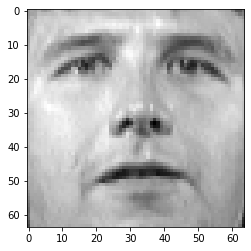

In [7]:
# ------------------ VIEW RANDOM IMAGE ------------------ #
index = int(random.random() * m)
index = 0
image = images[index,:,:]
# name = target_names[y[index]]

# print(name)
plt.imshow(image, cmap='gray')
plt.show()

In [8]:
# --------------------- GET FLATTEN IMAGES --------------------- #

# Flatten images array
# Each column is an image

# N^2 * M
flattened_images = train_images.reshape(m, -1).T

# N^2 * M_test
flattened_test_images = test_images.reshape(m_test, -1).T

print(f'Shape of training images after flattening: {flattened_images.shape}')
print(f'Shape of test images after flattening: {flattened_test_images.shape}')

Shape of training images after flattening: (4096, 320)
Shape of test images after flattening: (4096, 80)


Average image has shape: (4096, 1)


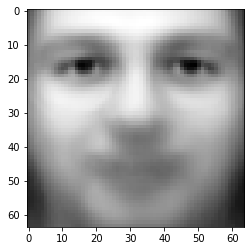

In [9]:
# ----------------- CALCULATE AVERAGE IMAGE ----------------- #

# In all corresponding pixels in all images, we calculate the average

# N^2 * 1
average_image = np.mean(flattened_images, axis = 1)[:,np.newaxis]

print(f'Average image has shape: {average_image.shape}')
plt.imshow(average_image.reshape(height,width), cmap='gray')
plt.show()

In [10]:
#-------------------------------- GET DIFFERENCE IMAGES --------------------------------#

# Subtract the average image from all images
# This is done to remove the average face from all images
# N^2 * M
difference_images = flattened_images - average_image

print(f'Shape after subtracting average face: {difference_images.shape}')


Shape after subtracting average face: (4096, 320)


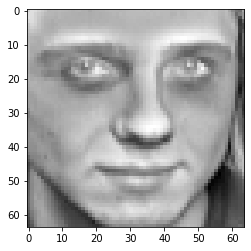

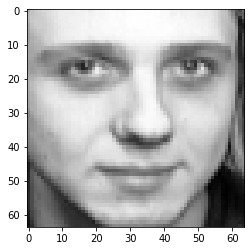

In [11]:
# --------------------- SHOW ONE DIFFERENCE IMAGE AND COMPARE TO ORIGINAL --------------------- #

index = int(random.random() * m)
# name = target_names[y_train[index]]

# print(name)
plt.imshow(difference_images[:,index].reshape(height, width), cmap='gray')
plt.show()

# Print original image
plt.imshow(images[index,:,:], cmap='gray')
plt.show()

In [12]:
#--------------------- GET COVARIANCE MATRIX --------------------- #

# C = A * A^T where A = difference_images

A = difference_images

# N^2 * N^2
covariance_matrix = np.matmul(difference_images, difference_images.T)

print('Shape of covariance matrix:', covariance_matrix.shape)

Shape of covariance matrix: (4096, 4096)


In [13]:
# --------------------------------- GET EIGENVALUES AND EIGENVECTORS --------------------------------- #

# Calculate the eigenvalues and eigenvectors of L
# where L = A^T * A

# M * M
L = np.matmul(A.T, A)

print('Shape of L:', L.shape)

# M eigenvalues and M eigenvectors
# where M is the number of examples

eigenvalues, eigenvectors = np.linalg.eig(L)
print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of eigenvectors:', eigenvectors.shape)


Shape of L: (320, 320)
Shape of eigenvalues: (320,)
Shape of eigenvectors: (320, 320)


In [14]:
# ------------------------ GET EIGENFACES FOR ALL IMAGES ------------------------ #

# Those Eigenvectors determine linear combinations of the M training set face images 
# to form the eigenfaces U

# difference_images: N^2 * M
# difference_images[:, i, np.newaxis]: N^2 * 1

# eigenvectors: M * M
# eigenvectors[:, i, np.newaxis]: M * 1

# N^2 * M
eigenfaces = np.zeros((n_features, m))

# TODO optimize the for loop
for i in range(m):
    eigenfaces += np.matmul(difference_images[:, i, np.newaxis], eigenvectors[:, i, np.newaxis].T)

print('Shape of eigenfaces:', eigenfaces.shape)


Shape of eigenfaces: (4096, 320)


In [15]:
# ------------------------ GET TOP EIGENFACES ------------------------ #

num_eigenfaces = 100

# Top eigenvalues indices
top_eigenvalues_indices = np.argsort(eigenvalues)[-num_eigenfaces:]

#  N^2 * num_eigenfaces
top_eigenfaces = np.zeros((n_features, num_eigenfaces))

i=0
for index in top_eigenvalues_indices:
    top_eigenfaces[:, i] = eigenfaces[:, index]
    i += 1

print(f"Top eigenfaces shape: {top_eigenfaces.shape}")

Top eigenfaces shape: (4096, 100)


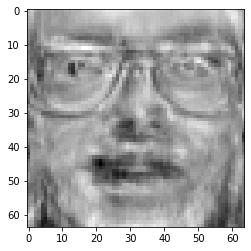

In [16]:
# ------------------------ SHOW A RANDOM EIGENFACE ------------------------ #

index = int(random.random() * m)
# name = target_names[y_train[index]]

# print(name)
plt.imshow(eigenfaces[:,index].reshape(height, width), cmap='gray')
plt.show()


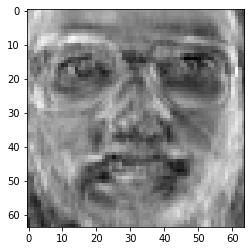

In [17]:
# ------------------------ SHOW A RANDOM EIGENFACE FROM TOP   ------------------------ #

index = int(random.random() * num_eigenfaces)
# name = target_names[y_train[index]]

# print(name)
plt.imshow(top_eigenfaces[:,index].reshape(height, width), cmap='gray')
plt.show()


In [18]:
# ------------------------ CALCULATING OMEGAS (OMEGA FOR EACH PERSON) ------------------------ #

# For each person, take a small number of face images (Here we took all), then calculate the eigenface representation of each image, then average it
# The result is the omega for that person omega is a vector of size num_eigenfaces with weight for each eigenface

# num_people * num_eigenfaces
omegas = np.zeros((num_people, num_eigenfaces))

for person in range(num_people):
    
    image = np.zeros((n_features, 1))
    
    image_indices = person_image_dict[person]
    
    # Loop over all images of a person
    for img in image_indices:
        # Get current Image of this person
        image = flattened_images[:, img, np.newaxis]
        # Get difference between current image and average image
        diff = image - average_image
        # Loop over all the top eigenfaces
        for i in range(num_eigenfaces):
            # Sum up the dot product of the difference image and the top eigenface
            omegas[person, i] += np.matmul(top_eigenfaces[:, i, np.newaxis].T , diff)
            
    omegas[person,:] = omegas[person,:] / len(image_indices)
    
print(f"Omegas shape: {omegas.shape}")

Omegas shape: (40, 100)


## Testing

Test image has shape: (4096, 1)
shape of w: (100,)
4096


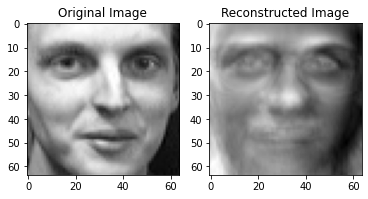

In [19]:
# -------------------------------------- TESTING SINGLE IMAGE -------------------------------------- #

index = int(random.random() * test_images.shape[0])

test_image = flattened_test_images[:,index, np.newaxis]
print(f'Test image has shape: {test_image.shape}')

w = np.zeros((num_eigenfaces,))
diff = test_image - average_image

for i in range(num_eigenfaces):
    w[i] = np.matmul(eigenfaces[:,i, np.newaxis].T,diff)
    
print(f"shape of w: {w.shape}")


# Visualize the image as a linear combination of the eigenfaces
print(n_features)
reconstructed_image = np.zeros((n_features,))
for i in range(num_eigenfaces):
    reconstructed_image += w[i] * eigenfaces[:,i]


# Show the reconstructed image and the original image next to each other
plt.subplot(1, 2, 1, title='Original Image')
plt.imshow(test_image.reshape(height, width), cmap='gray')
plt.subplot(1, 2, 2, title='Reconstructed Image')
plt.imshow(reconstructed_image.reshape(height, width), cmap='gray')
plt.show()




# Calculate the distance between w of the test image and omegas of all people
# The person with the smallest distance is the person in the test image

min_distance = float('inf')
nearest_person = -1

for person in range(num_people):
    distance = np.linalg.norm(w - omegas[person, :])
    if(distance < min_distance):
        min_distance = distance
        nearest_person = person
    # print(f'Distance between test image and {target_names[person]} is {distance}')

threshold = float('inf')
if (min_distance < threshold):
    pass
    # print(f'The nearest person is {target_names[nearest_person]}')
    # print(f'True person: {target_names[y[index]]}')
else:
    print('No person found')

In [20]:
# ---------------------------- TESTING ACCURACY ---------------------------- #

count = 0
trials = 1000
for trial in range(trials):
    # Get test image index randomly
    index = int(random.random() * m_test)
    
    # Get image
    test_image = flattened_test_images[:,index, np.newaxis]

    # Calculate the image weight
    w = np.zeros((num_eigenfaces,))
    for i in range(num_eigenfaces):
        w[i] = np.matmul(eigenfaces[:,i, np.newaxis].T, test_image - average_image)

    min_distance = float('inf')
    nearest_person = -1

    for person in range(num_people):
        distance = np.linalg.norm(w - omegas[person,:])
        if(distance < min_distance):
            min_distance = distance
            nearest_person = person

    threshold = float('inf')
    if (min_distance < threshold):
        if(nearest_person == y_test[index]):
            count += 1
print(f'Accuracy: {count/trials*100}%')

Accuracy: 3.3000000000000003%
